# Lab 9 : Linear Classification

# 1. Load the dataset

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd


DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [3]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path, 0) #Load the gray image
            #Resizing
            img = cv2.resize(src=img, dsize=img_shape)
            #Normalization
            img = img/255
            #Add the image in the feature matrix and its labels to the label vector
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y

labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)


Feature matrix : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


# 2. PCA

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config

# Scoring
from sklearn.metrics import roc_auc_score
# PCA
from sklearn.decomposition import PCA

In [5]:
set_config(display="diagram")
pca = PCA(n_components=90)

In [6]:
pca.fit_transform(X)
X_pca = pca.transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.25, random_state=42)

In [8]:
def multi_class_to_binary(Y, target_class, labels):
    idx = np.where(Y==target_class)[0]
    Y_binary = np.zeros(Y.shape)
    Y_binary[idx] = 1
    binary_labels = ['others', labels[target_class]]
    return Y_binary, binary_labels

# 3. Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score

import datetime

## 3.1 Logistic Regression for each class (binary classification)

In [10]:
conf_matrices = []
labels_binary = []
logistic_reg = []

for i in range(len(labels)):
    Y_binary_train_i, labels_binary_i = multi_class_to_binary(y_train, i, labels)
    Y_binary_test_i, _ = multi_class_to_binary(y_test, i, labels)
    logisticReg = LogisticRegression(max_iter=500)
    t0 = datetime.datetime.now()
    print('---'*10)
    print('Training of Logistic Reg for target class {} - {}'.format(i, labels_binary_i[-1]))
    logisticReg.fit(X_train, Y_binary_train_i)
    tf = datetime.datetime.now() - t0
    print('Training time : {}'.format(tf))
    y_pred = logisticReg.predict(X_test)
    cm_i = confusion_matrix(Y_binary_test_i, y_pred)
    conf_matrices.append(cm_i)
    labels_binary.append(labels_binary_i)
    logistic_reg.append(logisticReg)
    print('Accuracy on test set  : {}'.format(accuracy_score(Y_binary_test_i, y_pred)))

------------------------------
Training of Logistic Reg for target class 0 - Black Sea Sprat
Training time : 0:00:00.198003
Accuracy on test set  : 0.9
------------------------------
Training of Logistic Reg for target class 1 - Gilt-Head Bream
Training time : 0:00:00.160439
Accuracy on test set  : 0.9237037037037037
------------------------------
Training of Logistic Reg for target class 2 - Hourse Mackerel
Training time : 0:00:00.205085
Accuracy on test set  : 0.9251851851851852
------------------------------
Training of Logistic Reg for target class 3 - Red Mullet
Training time : 0:00:00.138333
Accuracy on test set  : 0.9377777777777778
------------------------------
Training of Logistic Reg for target class 4 - Red Sea Bream
Training time : 0:00:00.199370
Accuracy on test set  : 0.9162962962962963
------------------------------
Training of Logistic Reg for target class 5 - Sea Bass
Training time : 0:00:00.183156
Accuracy on test set  : 0.9177777777777778
---------------------------

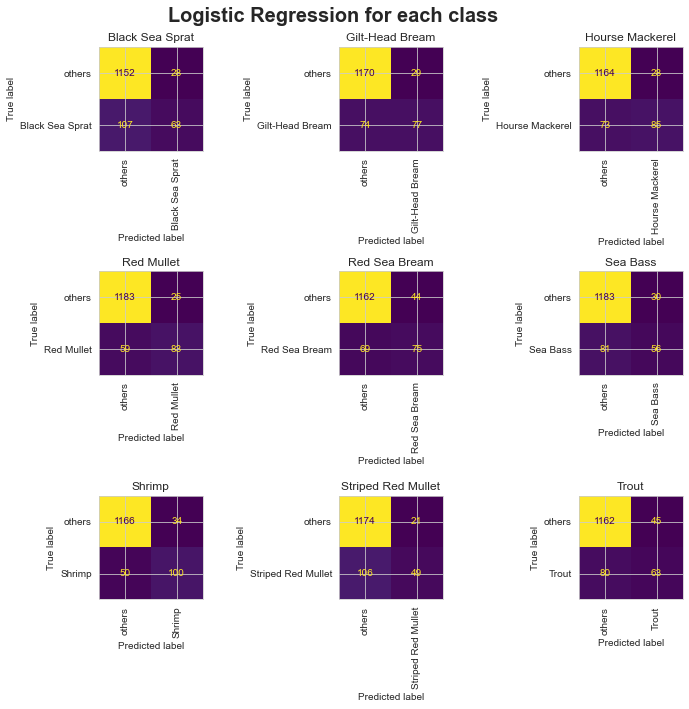

In [11]:

f, axes = plt.subplots(3, 3, figsize=(10, 10))
f.suptitle('Logistic Regression for each class', fontweight='bold', size=20)

idx = 0
for i in range(3):
    for j in range(3):
        disp = ConfusionMatrixDisplay(conf_matrices[idx], display_labels=[0,1])
        disp.plot(ax=axes[i, j], xticks_rotation=90)
        disp.ax_.set_xticklabels(labels_binary[idx])
        disp.ax_.set_yticklabels(labels_binary[idx])
        disp.ax_.set_title(labels[idx])
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('Predicted label')
        idx +=1


plt.tight_layout()
plt.show()

## 3.2 Use the trained binary classifiers to build a multi-class classifier

In [12]:
class Multi_class_Model:

    def __init__(self, logistic_reg=None, labels=None):
        self.__logistic_regs = logistic_reg
        self.__labels = labels

    def predict(self, X):
        if self.__logistic_regs is None or self.__labels is None:
            print('Please fit the model before using predict or instantiate the model with the trained logistic Regression models')
            return
        y_pred_i = self.__logistic_regs[0].predict_proba(X)[:, 1]
        y_pred_i = y_pred_i.reshape((X.shape[0], 1))
        predict_prob = y_pred_i
        for i in range(1, len(self.__logistic_regs)):
            y_pred_i = self.__logistic_regs[i].predict_proba(X)[:, 1]
            y_pred_i = y_pred_i.reshape((X.shape[0], 1))
            predict_prob = np.concatenate((predict_prob, y_pred_i), axis=1)
        return np.argmax(predict_prob, axis=1)

    def fit(self, X_train, X_test, y_train, y_test, labels):
        self.__conf_matrices = []
        self.__labels_binary = []
        self.__logistic_regs = []
        self.__labels = labels
        for i in range(len(self.__labels)):
            Y_binary_train_i, labels_binary_i = multi_class_to_binary(y_train, i, self.__labels)
            Y_binary_test_i, _ = multi_class_to_binary(y_test, i, self.__labels)
            logisticReg = LogisticRegression(max_iter=500)
            t0 = datetime.datetime.now()
            print('---'*10)
            print('Training of Logistic Reg for target class {} - {}'.format(i, labels_binary_i[-1]))
            logisticReg.fit(X_train, Y_binary_train_i)
            tf = datetime.datetime.now() - t0
            print('Training time : {}'.format(tf))
            y_pred = logisticReg.predict(X_test)
            cm_i = confusion_matrix(Y_binary_test_i, y_pred)
            self.__conf_matrices.append(cm_i)
            self.__labels_binary.append(labels_binary_i)
            self.__logistic_regs.append(logisticReg)
            print('Accuracy on test set  : {}'.format(accuracy_score(Y_binary_test_i, y_pred)))

    def plot_binary_models_cm(self):
        f, axes = plt.subplots(3, 3, figsize=(10, 10))
        f.suptitle('Logistic Regression for each class', fontweight='bold', size=20)

        idx = 0
        for i in range(3):
            for j in range(3):
                disp = ConfusionMatrixDisplay(self.__conf_matrices[idx], display_labels=[0,1])
                disp.plot(ax=axes[i, j], xticks_rotation=90)
                disp.ax_.set_xticklabels(self.__labels_binary[idx])
                disp.ax_.set_yticklabels(self.__labels_binary[idx])
                disp.ax_.set_title(self.__labels[idx])
                disp.im_.colorbar.remove()
                disp.ax_.set_xlabel('Predicted label')
                idx +=1

        plt.tight_layout()
        plt.show()

In [13]:
model = Multi_class_Model(logistic_reg, labels)

In [14]:
model.fit(X_train, X_test, y_train, y_test, labels)

------------------------------
Training of Logistic Reg for target class 0 - Black Sea Sprat
Training time : 0:00:00.114596
Accuracy on test set  : 0.9
------------------------------
Training of Logistic Reg for target class 1 - Gilt-Head Bream
Training time : 0:00:00.166255
Accuracy on test set  : 0.9237037037037037
------------------------------
Training of Logistic Reg for target class 2 - Hourse Mackerel
Training time : 0:00:00.207662
Accuracy on test set  : 0.9251851851851852
------------------------------
Training of Logistic Reg for target class 3 - Red Mullet
Training time : 0:00:00.165771
Accuracy on test set  : 0.9377777777777778
------------------------------
Training of Logistic Reg for target class 4 - Red Sea Bream
Training time : 0:00:00.134674
Accuracy on test set  : 0.9162962962962963
------------------------------
Training of Logistic Reg for target class 5 - Sea Bass
Training time : 0:00:00.167202
Accuracy on test set  : 0.9177777777777778
---------------------------

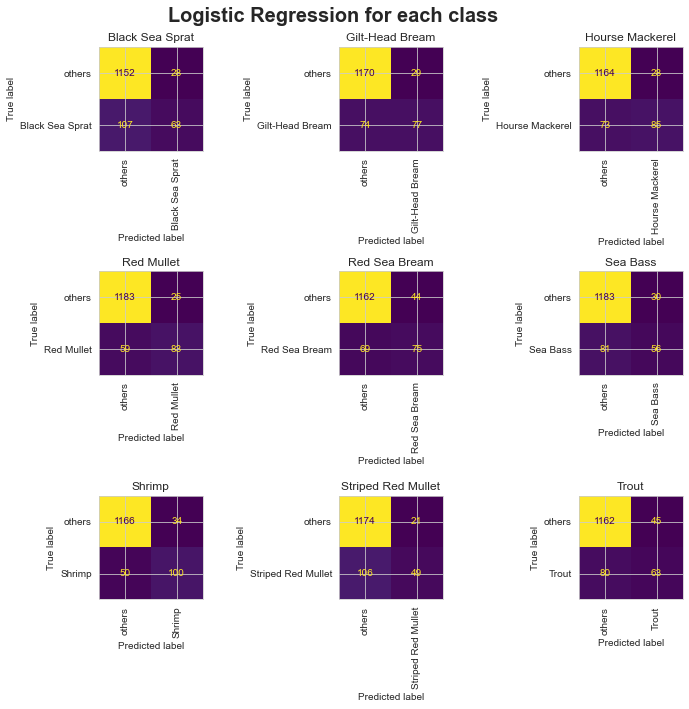

In [15]:
model.plot_binary_models_cm()

In [16]:
y_pred = model.predict(X_test)

In [17]:
print(y_pred)

[5 1 5 ... 3 7 8]


In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.56      0.62       170
         1.0       0.67      0.59      0.63       151
         2.0       0.61      0.70      0.65       158
         3.0       0.72      0.73      0.72       142
         4.0       0.62      0.62      0.62       144
         5.0       0.57      0.68      0.62       137
         6.0       0.75      0.84      0.79       150
         7.0       0.63      0.50      0.56       155
         8.0       0.59      0.66      0.62       143

    accuracy                           0.65      1350
   macro avg       0.65      0.65      0.65      1350
weighted avg       0.65      0.65      0.65      1350



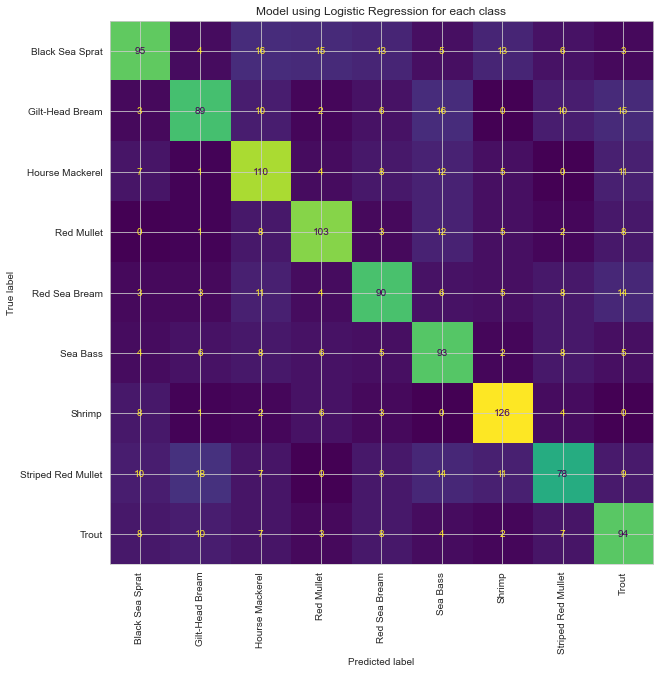

In [20]:
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(1,1, figsize=(10, 10))

disp = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(9)])
disp.plot(ax=ax, xticks_rotation=90)
disp.ax_.set_xticklabels(labels)
disp.ax_.set_yticklabels(labels)
disp.ax_.set_title('Model using Logistic Regression for each class')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label')
plt.show()

## 3.3 Logistic Regression applied directly to multiclass

In [21]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test, params):
    search = GridSearchCV(estimator=pipeline, param_grid=params, scoring='accuracy', cv=10)
    search.fit(X_train, y_train)
    search.score(X_train, y_train)
    print("Best params found : ", search.best_params_)
    print("Score : ", search.score(X_test, y_test))
    return search

In [22]:
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
#multi_class = ['ovr', 'multinomial']
max_iter = [500]
pipeline_LR = Pipeline([('LR', LogisticRegression())])
params_LR = {
    'LR__solver' : solver,
    #'LR__multi_class':multi_class,
    'LR__max_iter':max_iter
}

searchLR = run_pipeline(pipeline_LR, X_train, X_test, y_train, y_test, params_LR)

Best params found :  {'LR__max_iter': 500, 'LR__solver': 'newton-cg'}
Score :  0.66


# 4. Stochastic Gradient Descent Classifier

In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
loss = ['squared_loss', 'perceptron', 'hinge']
l_rate = [0.001, 0.0001]

pipeline_SGD = Pipeline([('SGD', SGDClassifier())])
params_SGD = {
    'SGD__loss' : loss,
    'SGD__eta0':l_rate,
    'SGD__learning_rate':['optimal']
}

searchSGD = run_pipeline(pipeline_SGD, X_train, X_test, y_train, y_test, params_SGD)

Best params found :  {'SGD__eta0': 0.001, 'SGD__learning_rate': 'optimal', 'SGD__loss': 'hinge'}
Score :  0.5474074074074075


## 5. Ridge Classifier

In [29]:
from sklearn.linear_model import RidgeClassifier

In [32]:
solver = ['sparse_cg', 'cholesky', 'svd', 'lsqr', 'sag', 'saga']

pipeline_Ridge = Pipeline([('Ridge', RidgeClassifier())])
params_RC = {
    'Ridge__solver' : solver
}

searchRC = run_pipeline(pipeline_Ridge, X_train, X_test, y_train, y_test, params_RC)

Best params found :  {'Ridge__solver': 'lsqr'}
Score :  0.6029629629629629


## 6. Compare the best models

In [33]:
grids = [searchLR, searchSGD, searchRC]

In [39]:
def compute_cf_metrics(cm, grid_tuple):
    """
    Compute the metrics (FP, TP, TN, FN, TP, Sensitivity, Specificity, Precision, Recall, Accuracy and AUC) given a confusion matrix
    """
    metrics = {}

    # Compute the FP, FN, TP, TN metrics from the confusion matrix
    FP = (cm.sum(axis=0) - np.diag(cm))
    FN = (cm.sum(axis=1) - np.diag(cm))
    accuracy = np.diag(cm)/cm.sum(axis=0)
    TP = np.diag(cm)
    TN = (cm.sum() - (FP + FN + TP))

    # Save the value in the metrics dictionary
    metrics['FP'] = FP
    metrics['TP'] = TP
    metrics['TN'] = TN
    metrics['FN'] = FN
    metrics['TP'] = TP

    # Sensitivity, hit rate, recall, or true positive rate
    metrics['Sensitivity'] = TP/(TP+FN)
    # Specificity or true negative rate
    metrics['Specificity'] = TN/(TN+FP)
    # Precision or positive predictive value
    metrics['Precision'] = TP/(TP+FP)
    # Recall
    metrics['Recall'] = TP / (TP+FN)
    # Accuracy
    metrics['Accuracy'] = accuracy
    #metrics['AUC'] = roc_auc_score(y_test, grid_tuple[2], multi_class='ovr')
    return metrics

def display_metrics(cm_list, grid_tuples):
    """
    Display the metrics in a table and plot two histograms to compare the metrics of different models
    :param cm_list: list of confusion matrix of each model
    :param grid_tuples: list of each grid tuple
    :return:
    """
    metrics_df = [] #List of dataframe of averaged computed metrics for each model
    for i in range(len(cm_list)):
        cm_metrics = compute_cf_metrics(cm_list[i], grid_tuples[i])
        df = pd.DataFrame(cm_metrics).transpose()
        mean_metrics = pd.DataFrame(df.mean(axis=1))
        metrics_df.append(mean_metrics)
    #Create a DataFrame with all the results
    metrics_name = metrics_df[-1].index
    metrics_data = [metric_rep.values[:,0] for metric_rep in metrics_df]
    metrics_per_model = pd.DataFrame(metrics_data).T
    metrics_per_model.columns = [grid_tuple[-1] for grid_tuple in grid_tuples]
    metrics_per_model.index = metrics_name

    display_1_df = pd.DataFrame([metrics_per_model.T.FP, metrics_per_model.T.TP,  metrics_per_model.T.TN,  metrics_per_model.T.FN])
    display_2_df = pd.DataFrame([metrics_per_model.T.Sensitivity, metrics_per_model.T.Specificity,  metrics_per_model.T.Precision,  metrics_per_model.T.Recall, metrics_per_model.T.Accuracy])

    # Plot the histogram of the averaged metrics for each models
    display_1_df.plot.bar()
    plt.title('Linear Models evaluation (1/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    display_2_df.plot.bar()
    plt.title('Linear Models evaluation (2/2)')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    return metrics_per_model


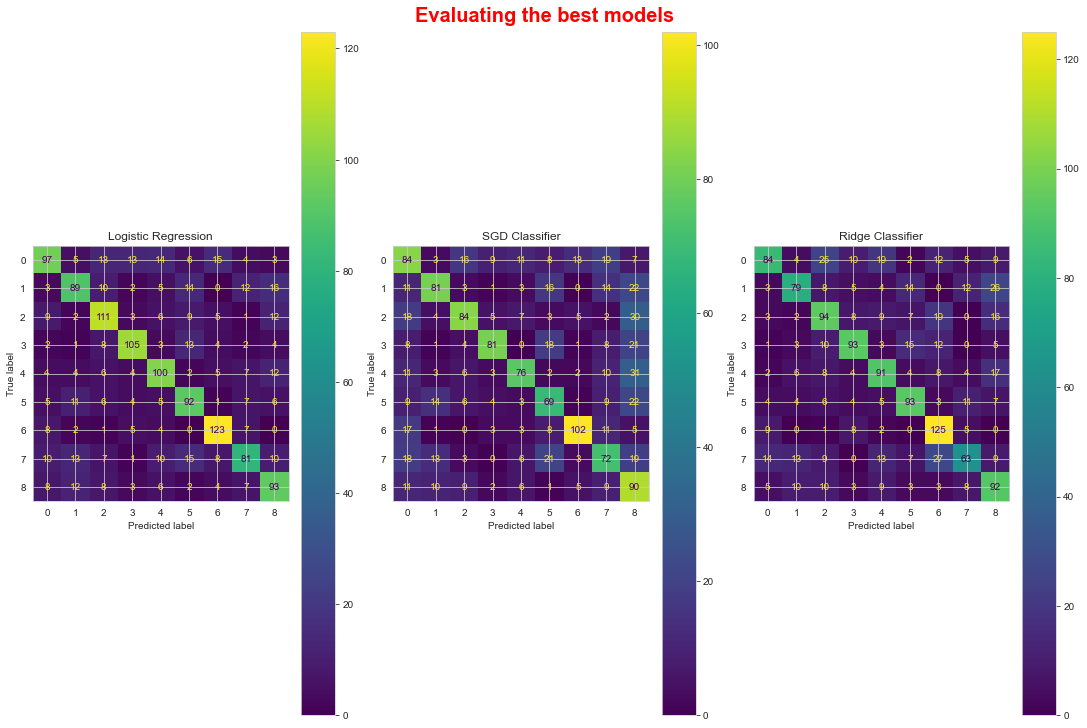

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

model_names = ["Logistic Regression", "SGD Classifier", "Ridge Classifier"]
model_list = [(params_LR, searchLR, "Logistic Regression"), (params_SGD, searchSGD, "SGD Classifier"), (params_RC, searchRC, "Ridge Classifier")]

grid_tuples = []
for idx, grid in enumerate(grids):
    grid_tuples.append((grid, grid.predict(X_test), None, model_names[idx]))

def plot_confusion_matrices(axs, grid_tuples):
    cm_list = []
    for i, grid_tuple in enumerate(grid_tuples):
        cm = confusion_matrix(y_test, grid_tuple[1])
        cm_display = ConfusionMatrixDisplay(cm)
        cm_display.plot(ax=axs[i])
        cm_display.ax_.set_title(grid_tuple[-1])
        cm_list.append(cm)
    return cm_list



fig = plt.figure(constrained_layout=True, figsize=(15, 10))
fig.suptitle('Evaluating the best models', fontweight='bold', size=20, color='red')
ax = fig.subplots(1, len(grid_tuples))
cm_list = plot_confusion_matrices(ax, grid_tuples)

,FP,TP,TN,FN,Sensitivity,Specificity,Precision,Recall,Accuracy
Logistic Regression,51.000000,99.000000,1149.000000,51.000000,0.662319,0.957505,0.659659,0.662319,0.659659
SGD Classifier,67.888889,82.111111,1132.111111,67.888889,0.548658,0.943395,0.577956,0.548658,0.577956
Ridge Classifier,59.555556,90.444444,1140.444444,59.555556,0.606787,0.950392,0.609075,0.606787,0.609075


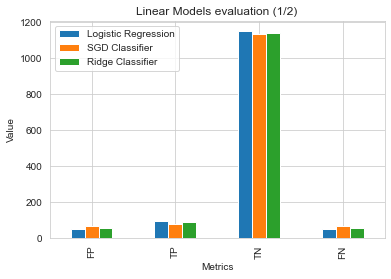

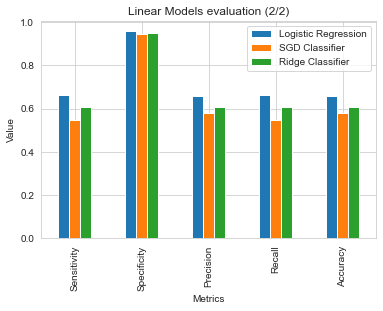

In [41]:
metric_df = display_metrics(cm_list, grid_tuples)
metric_df.T